In [2]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
from BoschUtils import sampled_data_set, general_df, use_cols_list, entire_data_set
%matplotlib inline

In [3]:
# 入力ファイルの皆さん

TRAINS = [
#     "../output/reduced_train_date_normalized.csv.gz",
    "../output/reduced_train_numeric.csv.gz",
#     "../output/reduced_train_date.csv.gz",
#     "../output/reduced_train_categorical.csv.gz",
    "../output/train_categorical_L3_S32_F3854.csv.gz",
    "../output/date_diff_train.csv.gz",
    "../output/train_categorical_md5.csv.gz",
    "../output/train_date_md5.csv.gz",
    "../output/train_categorical_set.csv.gz"
]

TESTS = []

for file in TRAINS:
    TESTS.append(file.replace("train", "test"))

RESPONSE = "../output/train_response.csv.gz"

In [4]:
%%time
# 全入力データを読み込み
X = sampled_data_set(TRAINS)
y = general_df(RESPONSE).loc[X.index].values.ravel()
X = X.values

../output/reduced_train_numeric.csv.gz
../output/train_categorical_L3_S32_F3854.csv.gz
../output/date_diff_train.csv.gz
../output/train_categorical_md5.csv.gz
../output/train_date_md5.csv.gz
../output/train_categorical_set.csv.gz
CPU times: user 2min 1s, sys: 7.31 s, total: 2min 9s
Wall time: 2min 9s


In [9]:
%%time
# XGBoost の時間だめう！
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

CPU times: user 47min 38s, sys: 6.21 s, total: 47min 44s
Wall time: 3min 20s


[ 10 114 200 320 321 338 341 345 360 375 392 394 681 682 688 690 702 704
 730 731 734 735 751 771 780 786 798 799 818 826 828 831 838 839 841 843
 848 850 851 854 862 872 883 884 885 968 969 970 971 972 988 994]


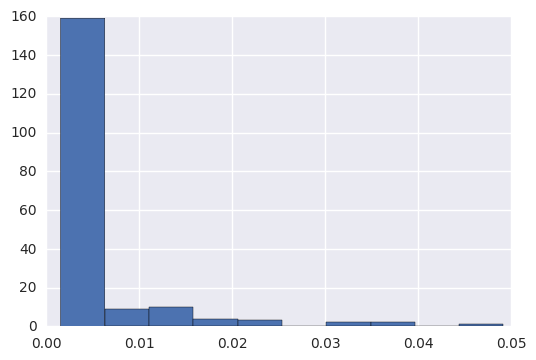

In [10]:
# とりあえず抽出
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_ > 0.005)[0]
print(important_indices)

In [11]:
# 入力データを削減
cols_list = use_cols_list(TRAINS, important_indices)
X = entire_data_set(TRAINS, cols_list)
y = general_df(RESPONSE).values.ravel()

../output/reduced_train_numeric.csv.gz [  0  11 115 201 321 322 339 342 346 361 376 393 395 682 683 689 691 703
 705 731 732 735 736 752 772 781 787 799 800 819 827 829 832 839 840 842
 844 849 851 852 855 863 873 884 885 886]
../output/train_categorical_L3_S32_F3854.csv.gz [0 1]
../output/date_diff_train.csv.gz [0 1 2 3]
../output/train_categorical_md5.csv.gz [0 1]
../output/train_date_md5.csv.gz [0]
../output/train_categorical_set.csv.gz [ 0 15 21]


In [12]:
# 予測して Cross Validation
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
predictions = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    predictions[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], predictions[test])))
print(roc_auc_score(y, predictions))

fold 0, ROC AUC: 0.721
fold 1, ROC AUC: 0.704
fold 2, ROC AUC: 0.701
0.708037128507


0.250376658601


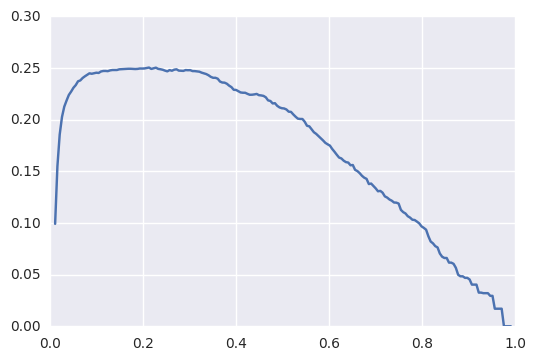

In [13]:
# MCC 最適化
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y, predictions > thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [14]:
# この時点での当たり具合を出力
tmp_threshold = best_threshold
response = pd.read_csv("../output/train_response.csv.gz", index_col=0)
response["prediction"] = predictions
predicted_one = response[response["prediction"] > tmp_threshold].groupby("Response").count()
predicted_one.rename(columns={"prediction":"Predict 1.0"}, inplace=True)
predicted_zero = response[response["prediction"] <= tmp_threshold].groupby("Response").count()
predicted_zero.rename(columns={"prediction":"Predict 0.0"}, inplace=True)
pd.concat([predicted_one, predicted_zero], axis=1)

,Predict 1.0,Predict 0.0
Response,,
0.0,1800,1175068
1.0,1138,5741


提出用データを生成する

In [ ]:
# テストデータ読み込み
X = entire_data_set(TESTS, cols_list)

# 0 or 1 に正規化
predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)

# 提出データを生成
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = predictions
sub.to_csv("submission.csv.gz", compression="gzip")